In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from utils import read_coco_annotations
import cv2

from albumentations import (
    BboxParams,
    HorizontalFlip,
    VerticalFlip,
    Resize,
    CenterCrop,
    RandomCrop,
    Crop,
    Compose,
    Rotate,
    ReplayCompose,
    Normalize
)


In [2]:
BOX_COLOR = (255, 0, 0)
TEXT_COLOR = (255, 255, 255)


def visualize_bbox(img, bbox, color=BOX_COLOR, thickness=2):
    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)

    return img


def visualize(annotations):
    img = annotations['image'].copy()
    for idx, bbox in enumerate(annotations['bboxes']):
        img = visualize_bbox(img, bbox)
    plt.figure(figsize=(12, 12))
    plt.imshow(img)

In [3]:
import json
def read_coco_annotations(file_path):

    with open(file_path) as json_file:
        data = json.load(json_file)
        
    return data

In [90]:
class SheepGridDataset2(Dataset):

    def __init__(self, labels_path, image_path, root_dir, transform=None, grid_shape=(3,3)):

        self.labels = read_coco_annotations(os.path.join(root_dir,labels_path))
        self.image_path = image_path
        self.root_dir = root_dir
        self.transform = transform
        self.grid_shape = grid_shape


    
    def get_keys(self):
        return list(self.labels.keys())
    
    def get_grid_shape(self):
        return self.grid_shape    
    
    
    def transform_augment(self, sample):
        

        
        return transformed_rgb, transformed_ir
    
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):

        key = list(self.labels.keys())[idx]
        print(key)
        label = self.labels[key]

        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_rgb_full_path = os.path.join(self.root_dir,
                                self.image_path, 'rgb',key)
        image_rgb = io.imread(img_rgb_full_path)
        
        img_ir_full_path = os.path.join(self.root_dir,
                                self.image_path, 'infrared',key)
        image_ir = io.imread(img_ir_full_path)

        
        
        sample = {'rgb': {'image': image_rgb,
                         'bboxes': label,
                         'category_id': [0]*len(label)},
                  'ir': {'image': image_ir,
                         'bboxes': label,
                         'category_id': [0]*len(label)},
                  'bboxes': label,
                  'category_id': [0]*len(label),
                  'key': key}

        # TRANSFORMS
        common_augmentations = get_aug([VerticalFlip(p=0.5),
                        HorizontalFlip(p=0.5),
                        Rotate(p=0.5,
                               limit=360),
                        RandomCrop(1200, 1200)
                       ])

        transformed_rgb = common_augmentations(**sample['rgb'])      
        transformed_ir_im = ReplayCompose.replay(transformed_rgb['replay'], image=sample['ir']['image'])['image']
        transformed_ir = transformed_rgb.copy()
        transformed_ir['image'] = transformed_ir_im
        
        rgb_only_transforms=  get_aug([
                        Resize(1184,1184),
                        Normali
                       ])
        
        
        
        
        transformed_rgb = rgb_only_transforms(**transformed_rgb)
        
        
        ir_only_transforms=  get_aug([
                        Resize(224,224),
                       ])
        
        transformed_ir= ir_only_transforms(**transformed_ir)
        
        sample['rgb'] = transformed_rgb
        sample['ir'] = transformed_ir

        return sample

In [91]:
def read_coco_annotations(file_path):
    with open(file_path) as json_file:
        data = json.load(json_file)
        
    return data

In [92]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [93]:
import matplotlib.patches as patches

def show_im_with_grid_labels(im, grid, grid_shape):
    print('show_im_with_grid_labels',im.shape, grid.shape, grid_shape )
    fig,ax = plt.subplots(figsize=(10,10))
    grid_2d = grid.reshape(-1, grid_shape[1])
    grid_w = im.shape[1]/grid_2d.shape[1]
    grid_h = im.shape[0]/grid_2d.shape[0]
    
    ax.imshow(im[:,:,:3])
    
    for x in range(grid_shape[1]):
        for y in range(grid_shape[0]):
            if grid_2d[y,x] > 0:
                rect = patches.Rectangle((x*grid_w,y*grid_h),grid_w,grid_h,linewidth=4,edgecolor='green',facecolor='green', alpha=0.1)      
            else:
                rect = patches.Rectangle((x*grid_w,y*grid_h),grid_w,grid_h,linewidth=2,edgecolor='white',facecolor='none')      
            ax.add_patch(rect)
    plt.draw()
    plt.show()


In [94]:
def get_aug(aug, min_area=0., min_visibility=0.):
    print('aug type', type(aug))
    return ReplayCompose(aug, bbox_params=BboxParams(format='coco', min_area=min_area, 
                                               min_visibility=min_visibility, label_fields=['category_id']))

oct19_103MEDIA_DJI_0590.JPG
aug type <class 'list'>
aug type <class 'list'>
aug type <class 'list'>
oct19_103MEDIA_DJI_0590.JPG
aug type <class 'list'>
aug type <class 'list'>
aug type <class 'list'>
oct19_103MEDIA_DJI_0590.JPG
aug type <class 'list'>
aug type <class 'list'>
aug type <class 'list'>


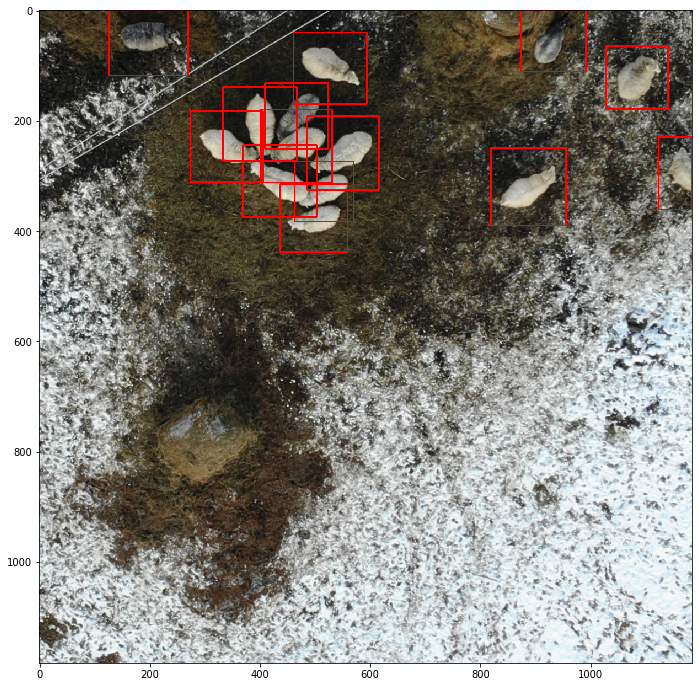

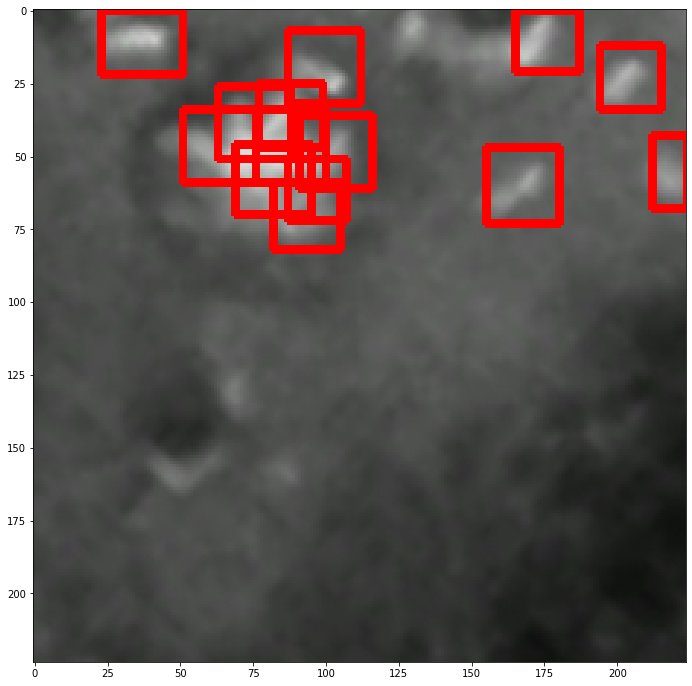

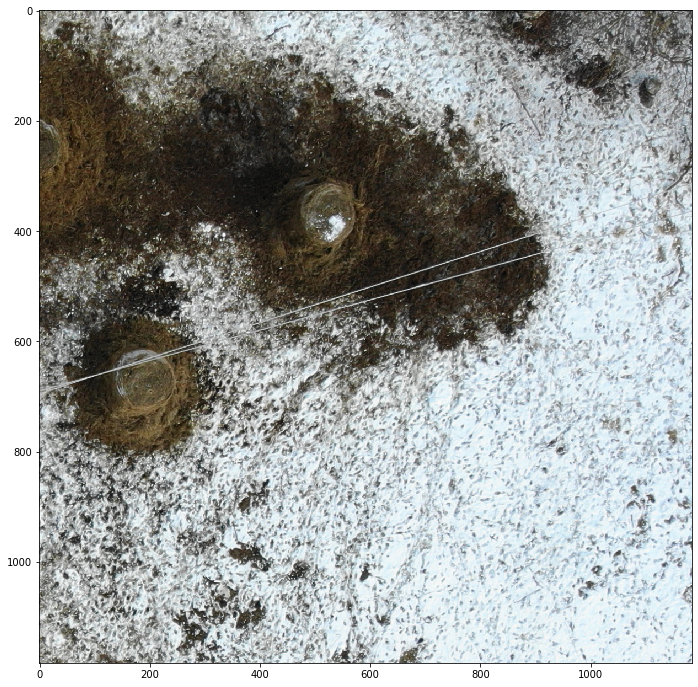

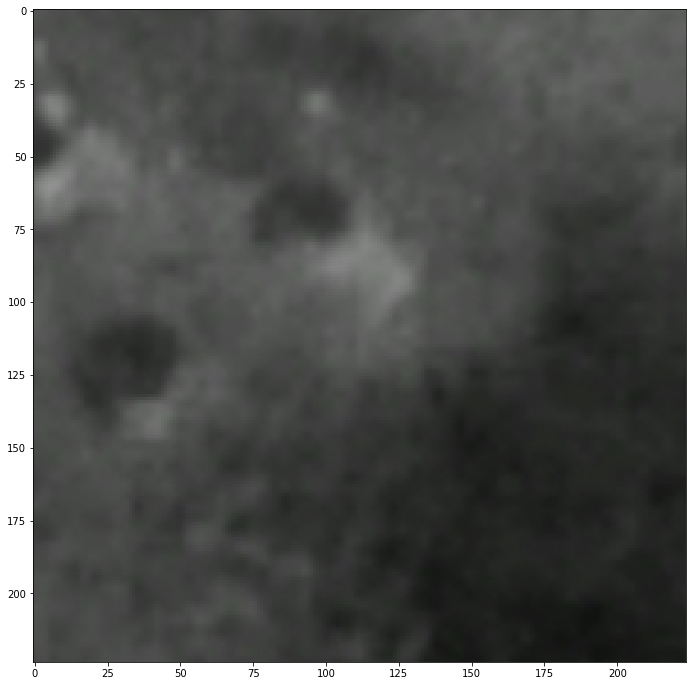

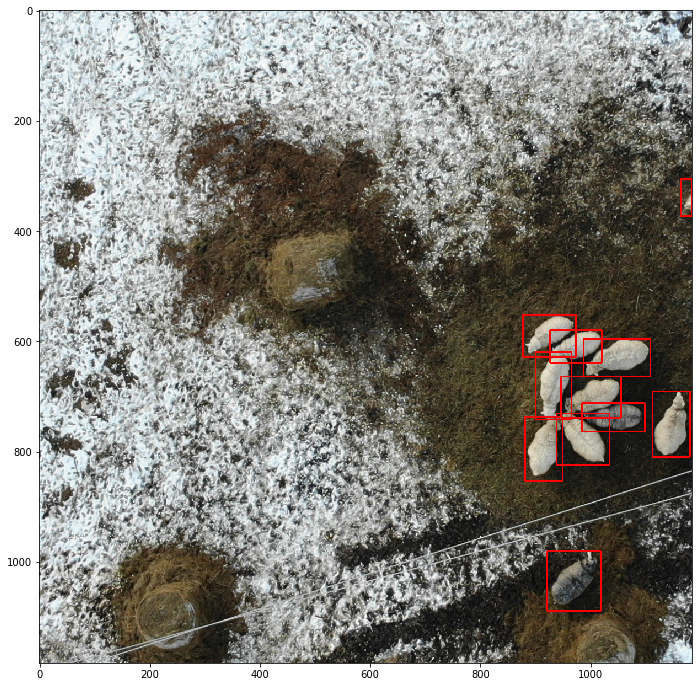

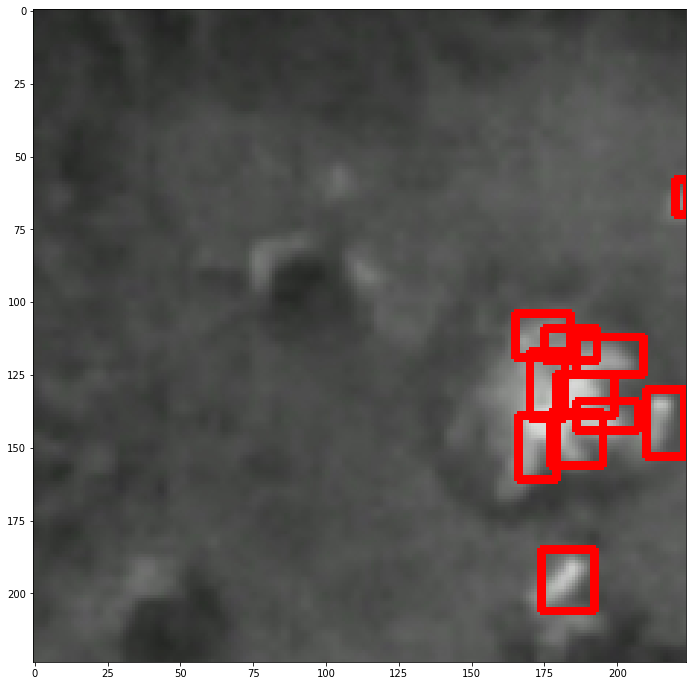

In [95]:
sheep_dataset = SheepGridDataset2(labels_path ='annotations/val2020_simple.json',
                                 image_path ='val2020',
                                 root_dir = './data/data_external/'
                                )

for i in range(3):
    sample = sheep_dataset[6]
    visualize(sample['rgb'])
    visualize(sample['ir'])


#ir_replay['category_id'] = transformed['category_id']
#visualize(ir_replay)

#transformed = all_augs(**sample['rgb'])
#visualize(transformed)

#replay:
#ir_replay = ReplayCompose.replay(transformed['replay'], image=sample['ir']['image'])
#ir_replay['bboxes'] = transformed['bboxes']
#ir_replay['category_id'] = transformed['category_id']
#visualize(ir_replay)


# COMMON AUGS rgb and ir:
#crop, flip, rotate, 


# DIFFERENT:
#resize, photo distortions, normalise

#augmented1 = aug1(**sample['rgb'])
#augmented2 = aug2(**augmented1)
#augmented3 = aug3(**augmented2)
#augmented4 = aug1(**augmented4)

#visualize(augmented1)
#visualize(augmented2)
#visualize(augmented3)
    




